# Install libraries

In [1]:
%%capture
!pip install polyglot
!pip install PyICU
!pip install pycld2
!pip install morfessor
!pip install fasttext
!pip install gensim
!pip install gdown
!pip install -U spacy

# Import libraries and settings

In [23]:
import re
import json
import nltk
import spacy
import requests
import warnings
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from polyglot.detect import Detector
from polyglot.detect.base import logger as polyglot_logger
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
polyglot_logger.setLevel("ERROR")
pd.set_option('display.max_colwidth', None)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/PortalNetworkNew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# Download the dataset and load it into dataframe

In [4]:
import pandas as pd
import gzip
import json

# Function to load the dataset
def load_dataset(file_path):
    data = []
    with gzip.open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return pd.DataFrame.from_dict(data)

original_data = load_dataset('./data/large/Gift_Cards.json.gz')

original_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1.0,25,False,"12 19, 2008",APV13CM0919JD,B001GXRQW0,{'Gift Amount:': ' 50'},LEH,"Amazon,\nI am shopping for Amazon.com gift cards for Christmas gifts and am really so disappointed that out of five choices there isn't one that says ""Merry Christmas"" or mentions Christmas at all! I am sure I am not alone in wanting a card that reflects the actual ""holiday"" we are celebrating. On principle, I cannot send a Amazon gift card this Christmas. What's up with all the Political Correctness? Bad marketing decision.\nLynn",Merry Christmas.,1229644800,NaN
1,5.0,NaN,False,"12 17, 2008",A3G8U1G1V082SN,B001GXRQW0,{'Gift Amount:': ' 50'},Tali,"I got this gift card from a friend, and it was the best! The site has so much to choose from... great gift.",Gift card with best selection,1229472000,NaN
2,5.0,4,False,"12 17, 2008",A11T2Q0EVTUWP,B001GXRQW0,{'Gift Amount:': ' 50'},Z,"aren't we going to save trees?! :) People who were complaining about paper gift cards can simply buy an electronic gift card via email. It's very convenient and indeed a great gift. I found paper gift cards annoying since you have to always wonder how much money you got left on it. And if you lose it, you lose it. An electronic delivery of the gift card makes it a lot of easier to redeem, you only need to COPY/PASTE the code into your gift certificate balance and it'll be there whenever you want to use it.\n\nI've sent friends electronic gift cards via email for their newborns, for their weddings, and for their housewarmings. :)\n\nHappy holidays",A convenient and great gift for the environment :-),1229472000,NaN
3,5.0,NaN,False,"12 17, 2008",A9YKGBH3SV22C,B001GXRQW0,{'Gift Amount:': ' 25'},Giotravels,"You can always get someone something from Amazon with the safety net that they can return it if they don't like it. But returning things is such a hassle. The card takes care of that--no more returns, no more hassles.",Totally make sense,1229472000,NaN
4,1.0,NaN,True,"12 17, 2008",A34WZIHVF3OKOL,B001GXRQW0,NaN,King Dad,"Why take 50 dollars of good money with no limitations, and turn it into Amazon money that can only be used at their site? Where is the benefit?\n\nAlso, you spend time and headache buying these types of cards, dealing with any activation issues risking expiration or delivery issues and then you have to keep up with them and keep track of how much you have remaining on the card....\n\nThey should at least give a discount for committing your purchasing power to them...",Give CASH!,1229472000,NaN


In [5]:
print(original_data.shape)

(147194, 12)


# Data Exploration

In [6]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147194 entries, 0 to 147193
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         147194 non-null  float64
 1   vote            6341 non-null    object 
 2   verified        147194 non-null  bool   
 3   reviewTime      147194 non-null  object 
 4   reviewerID      147194 non-null  object 
 5   asin            147194 non-null  object 
 6   style           42375 non-null   object 
 7   reviewerName    147190 non-null  object 
 8   reviewText      147035 non-null  object 
 9   summary         147154 non-null  object 
 10  unixReviewTime  147194 non-null  int64  
 11  image           406 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 12.5+ MB


In [7]:
print(original_data.head(5))

   overall vote  verified   reviewTime      reviewerID        asin  \
0      1.0   25     False  12 19, 2008   APV13CM0919JD  B001GXRQW0   
1      5.0  NaN     False  12 17, 2008  A3G8U1G1V082SN  B001GXRQW0   
2      5.0    4     False  12 17, 2008   A11T2Q0EVTUWP  B001GXRQW0   
3      5.0  NaN     False  12 17, 2008   A9YKGBH3SV22C  B001GXRQW0   
4      1.0  NaN      True  12 17, 2008  A34WZIHVF3OKOL  B001GXRQW0   

                     style reviewerName  \
0  {'Gift Amount:': ' 50'}          LEH   
1  {'Gift Amount:': ' 50'}         Tali   
2  {'Gift Amount:': ' 50'}            Z   
3  {'Gift Amount:': ' 25'}   Giotravels   
4                      NaN     King Dad   

                                                                                                                                                                                                                                                                                                                                

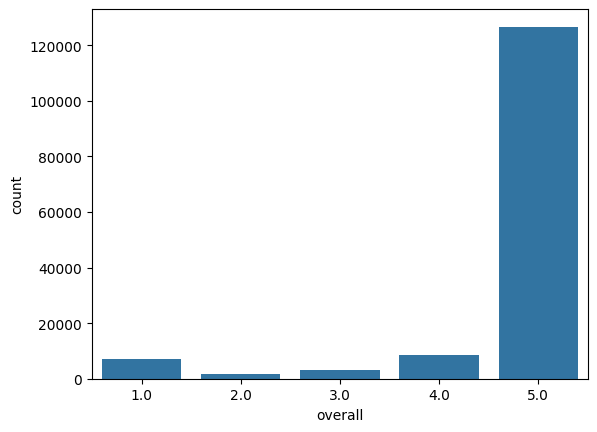

In [8]:
sns.countplot(x="overall", data=original_data)
plt.show()

# Drop items

In [9]:
# Justification why we drop 'verified'
non_verified_perc = len(original_data[original_data['verified'] == False])/len(original_data)
print(f"Non verified users is {non_verified_perc:.2%} of total data")

Non verified users is 6.09% of total data


In [10]:
verified_user_data = original_data[original_data['verified'] == True]
non_verified_user_data = original_data[original_data['verified'] == False]

In [11]:
verified_overall_counts = verified_user_data['overall'].value_counts(normalize=True) * 100
non_verified_overall_counts = non_verified_user_data['overall'].value_counts(normalize=True) * 100

print("Verified User Overall Ratings:")
print(verified_overall_counts.sort_values(ascending=False).apply("{:.2f}%".format))

print("\nNon-Verified User Overall Ratings:")
print(non_verified_overall_counts.sort_values(ascending=False).apply("{:.2f}%".format))


Verified User Overall Ratings:
overall
5.0    87.14%
4.0     5.93%
1.0     3.98%
3.0     1.96%
2.0     1.00%
Name: proportion, dtype: object

Non-Verified User Overall Ratings:
overall
5.0    69.58%
1.0    18.54%
4.0     5.68%
3.0     3.26%
2.0     2.94%
Name: proportion, dtype: object


The proportion of non-verified users are significantly different from the verified users. Moreover, it consists of only 6.09% of the total data.

It is considered as not credible data, and therefore the records are dropped.

In [12]:
# Drop records where 'verified' is False
trimmed_data = original_data[original_data['verified'] == True]
len(trimmed_data)

138237

In [13]:
# Justification why we drop 'reviewText is null'
null_review_text = len(trimmed_data[trimmed_data['reviewText'].isna()==True])/len(original_data)
print(f"Non verified users is {null_review_text:.2%} of total data")

Non verified users is 0.10% of total data


In [14]:
trimmed_data[trimmed_data['reviewText'].isna()==True]['summary'].value_counts()

summary
Five Stars                                                                                                                          126
Four Stars                                                                                                                            8
Very nice                                                                                                                             1
Always well received                                                                                                                  1
Awesome!                                                                                                                              1
Amazon $50 gift card i boight in a silver tin.                                                                                        1
Great stocking stuffer for teenagers!                                                                                                 1
All of the "slave" books were interestin

Proportion of null reviewText is low. Also, most of them are "Five Stars" or "Four Stars", which is not useful.

In [15]:
# Group the data by 'summary' and calculate the mean 'overall' rating for each group
summary_ratings = trimmed_data[trimmed_data['reviewText'].isna()==True].groupby('summary')['overall'].mean()

# Print the results
print(summary_ratings)

summary
All of the "slave" books were interesting & very different from normal fare in this genre. Unique!  I recommend the whole series    4.0
Always well received                                                                                                                5.0
Amazon $50 gift card i boight in a silver tin.                                                                                      1.0
Awesome!                                                                                                                            5.0
Five Stars                                                                                                                          5.0
Four Stars                                                                                                                          4.0
Great stocking stuffer for teenagers!                                                                                               5.0
Very nice                               

In [16]:
# Drop records with reviewText is null
trimmed_data[trimmed_data['reviewText'].isna()==True]
len(trimmed_data)

138237

In [17]:
short_review_data = trimmed_data[(trimmed_data['reviewText'].str.len()) <= 2]
short_review_data

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
109,5.0,NaN,True,"08 17, 2014",A2TVYVM95KL8VT,B001GXRQW0,{'Gift Amount:': ' 25'},Rebekah E. Spahn,:),Five Stars,1408233600,NaN
716,3.0,NaN,True,"02 20, 2015",A1PLPL3QHR0IKZ,B002BSHDJK,NaN,Jimmy D. Banks,ok,Three Stars,1424390400,NaN
1355,5.0,NaN,True,"01 17, 2016",AA1R3FP3MGQKH,B004KNWWTK,NaN,Stephen S.,e,Five Stars,1452988800,NaN
1702,5.0,NaN,True,"05 14, 2015",A1T636IN90QX2N,B004KNWWRM,NaN,Angela Stretz,:),Five Stars,1431561600,NaN
2019,5.0,NaN,True,"08 6, 2016",A1Y0A7W7O9LFH4,B004KNWX6C,NaN,Pamela B,Ok,Five Stars,1470441600,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
146331,5.0,NaN,True,"09 29, 2016",A50686PODHEOW,B017THJLZG,NaN,Janae B.,:),Five Stars,1475107200,NaN
146795,5.0,NaN,True,"09 19, 2018",A251GXMCOU9QWM,B01E4QPDV6,{'Gift Amount:': ' 75'},jo jo,ok,Five Stars,1537315200,NaN
146815,5.0,NaN,True,"08 10, 2018",AN4JTP3SPCKL0,B01E4QUN0W,{'Gift Amount:': ' 75'},Kenny Purden,Ok,Five Stars,1533859200,NaN
147010,5.0,NaN,True,"08 2, 2018",A1GQAKRTBNCSKG,B01G44QKQI,NaN,Poodle Lucy,OK,OK,1533168000,NaN


In [18]:
# Drop records that review lenght <=2
trimmed_data = trimmed_data[(trimmed_data['reviewText'].str.len()) > 2]
len(trimmed_data)

137373

In [19]:
long_review_data = trimmed_data[(trimmed_data['reviewText'].str.len()) > 1000]
long_review_data

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
499,5.0,NaN,True,"05 16, 2010",A5WHQAV2ACN7Z,B001GXRQW0,{'Gift Amount:': ' 50'},Patricia S. Burgess,"With children, adolescents, teens, and adults for whom I must shop for birthdays, anniversaries, and holidays, my poor brain gets overloaded with ideas and suggestions. Then, because we do not all live near one another or get to see on another regularly, I do not always have an idea of what they prefer. BUT. . .I found a sure cure way to please them all and get marvelous thank you notes!\n\nI am willing to share with you. I send Amazon gift cards!!!!!\n\nFor those I like a lot, I send a more expensive card, for those I am just remembering, I send a less expensive one. No matter, I know that my family and friends can go to Amazon.com and find something that they will really want and with which they will be pleased.\n\nI have had thank you notes for such varied things as towels, sheet music, transformers (that is a toy, I learned), and books. Not for a moment would I have thought of these gifts and yet they were gratefully received.\n\nAND, your ordering them is as easy as clicking your cursor on one of the links below, entering the information such as to whom it is to go, for how much, and your credit card information. BUT. . .the GREATEST thing is, if you forget and you are driving to work and remember your mother's birthday is TODAY (YIKES!), you can go to the link and have the card delivered to her computer THAT DAY!!!!!! She can shop for her gift before you get home from work! Now, you cannot beat that.\n\nSo, I highly recommend an Amazon.com gift card to solve your shopping woes.\n\n<a data-hook=""product-link-linked"" class=""a-link-normal"" href=""/Amazon-com-50-Gift-Card-0109/dp/B001H53QDK/ref=cm_cr_arp_d_rvw_txt?ie=UTF8"">Amazon.com $50 Gift Card (0109)</a>\n<a data-hook=""product-link-linked"" class=""a-link-normal"" href=""/50-Electronic-Gift-Certificate/dp/B0019LVYV8/ref=cm_cr_arp_d_rvw_txt?ie=UTF8"">$50 Electronic Gift Certificate</a>\n<a data-hook=""product-link-linked"" class=""a-link-normal"" href=""/Amazon-com-10-Gift-Card-Box-of-50-Cards/dp/B001H53QE4/ref=cm_cr_arp_d_rvw_txt?ie=UTF8"">Amazon.com $10 Gift Card - Box of 50 Cards</a>\n<a data-hook=""product-link-linked"" class=""a-link-normal"" href=""/100-Emitations-Email-Gift-Certificate/dp/B0039PL8SQ/ref=cm_cr_arp_d_rvw_txt?ie=UTF8"">$100 Emitations Email Gift Certificate</a>\n<a data-hook=""product-link-linked"" class=""a-link-normal"" href=""/75-Emitations-Email-Gift-Certificate/dp/B0039PJ45A/ref=cm_cr_arp_d_rvw_txt?ie=UTF8"">$75 Emitations Email Gift Certificate</a>",The Sure-to-be-a-Hit Birthday Gift,1273968000,NaN
779,5.0,2,True,"10 9, 2012",A3DK6CVDOBHJIO,B002BSHDJK,NaN,Andrew Smith,"This product gets five stars because it's exactly what it's advertised to be: a wire bird cage-style card holder (the type that's so fashionable at weddings these days). The top portion of the card holder is hinged and easily opens and closes. It also can be locked (lock of your choice sold separately) in case any unsavory individuals show up to your wedding/event (I'm looking at you, hotel bartender with the goatee who keeps making eyes at the maid of honor!). It decorates easily with ribbon / flowers to match your color scheme.\n\nMy only caveat about this card holder would be its actual size - it's small! Today's wedding cards are much too big to lay flat in this card holder. Also, many didn't even fit through the openings. And, if you have a family of impatient drunks (don't judge), cards easily get backed up. If you're having an event where you anticipate more than 20 - 25 cards, then please entertain other options. This card holder would be great at a bridal or baby shower, but unless you're having a small to moderately-sized wedding this card holder ain't going to cut it.\n\nAgain, it's a great product; just make sure you're aware of the size and plan accordingl

In [20]:
# Drop records that review lenght > 1000
trimmed_data = trimmed_data[(trimmed_data['reviewText'].str.len()) < 1000]
len(trimmed_data)

137148

In [21]:
[lang.confidence for lang in Detector(trimmed_data.iloc[4]["reviewText"]).languages]

[97.0, 0.0, 0.0]

In [24]:
# Detect the language
trimmed_data["language"] = trimmed_data['reviewText'].apply(lambda x: Detector(x, quiet=True).language.name)
trimmed_data["confidence"] = trimmed_data['reviewText'].apply(lambda x: Detector(x, quiet=True).language.confidence)

In [25]:
trimmed_data['language'].value_counts()

language
English              135452
Spanish                 651
Romanian                257
Norwegian Nynorsk       177
un                       83
                      ...  
Scottish Gaelic           1
Tswana                    1
Albanian                  1
Bosnian                   1
Sundanese                 1
Name: count, Length: 83, dtype: int64

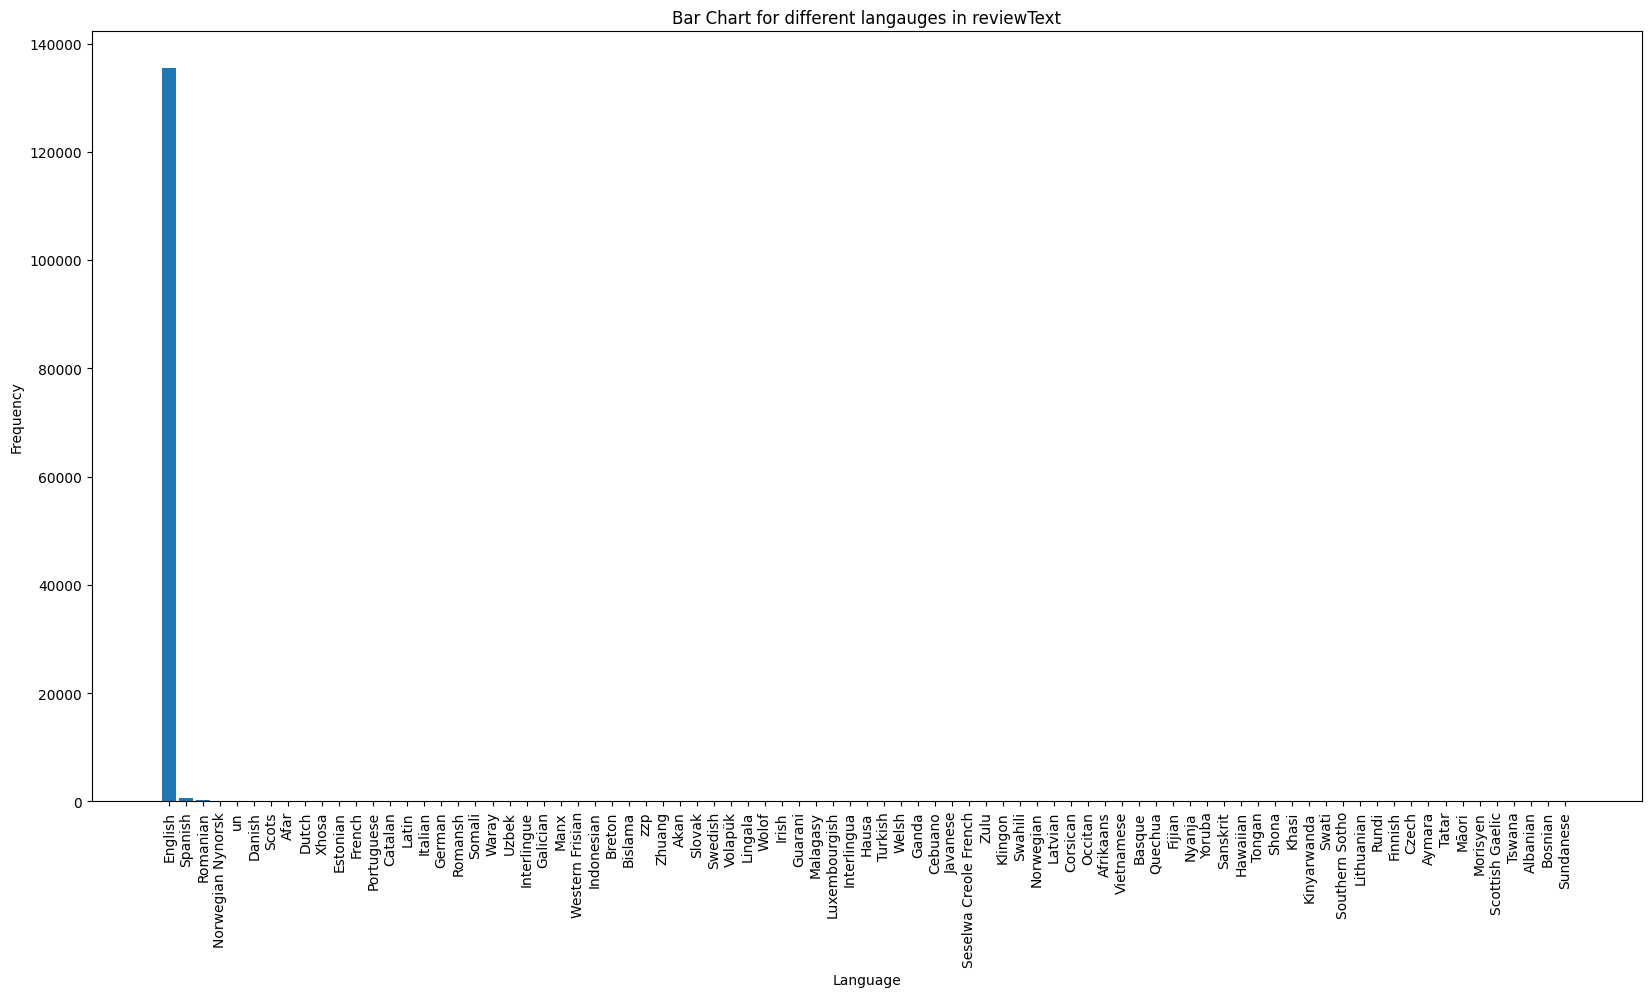

In [26]:
plt.figure(figsize=(20, 10))
plt.bar(trimmed_data['language'].value_counts().index, trimmed_data['language'].value_counts().values)
plt.title('Bar Chart for different langauges in reviewText')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.xticks(rotation=90);

In [27]:
# show spanish review text
(trimmed_data[trimmed_data["language"] == "Spanish"])["reviewText"]

97                                                                                                                                                                                                                      Exelente
217                                                                                                                            muy buenoo lo recomiendo excelente envio todooo estuvo finisimo . . . . . . . . . . . . excelente
218       Buenas Noches! compre un GC de 10$ y entendi que me la enviaran por correo ahora resulta que me la enviaron a florida y el flete a venezuela es muchisimooo ms caro que la tarjeta en si. me podria explicar que paso?
225                                                                             buena, uanque no manejo muy bien la utilizacin, podr utilizarla para proximas compras, excelente, entrega rpida y segura, los recomiendo,gracias
238                                                                                                 

In [28]:
# show un review text
(trimmed_data[trimmed_data["language"] == "un"])["reviewText"]

25                           :-)
1172                   Nice Pics
3500                         :-)
7039                         :-)
7976       Any price , any style
                   ...          
140179                      100%
140924                       :-)
142833                Very clasy
143756                       :-)
144083    Quick and classy gift.
Name: reviewText, Length: 83, dtype: object

In [29]:
# choose all English and check the confience level
trimmed_data = trimmed_data[trimmed_data["language"] == "English"]

In [30]:
trimmed_data['confidence'].describe()

count    135452.000000
mean         96.243245
std           3.842200
min          52.000000
25%          95.000000
50%          98.000000
75%          99.000000
max          99.000000
Name: confidence, dtype: float64

Text(0, 0.5, 'Frequency')

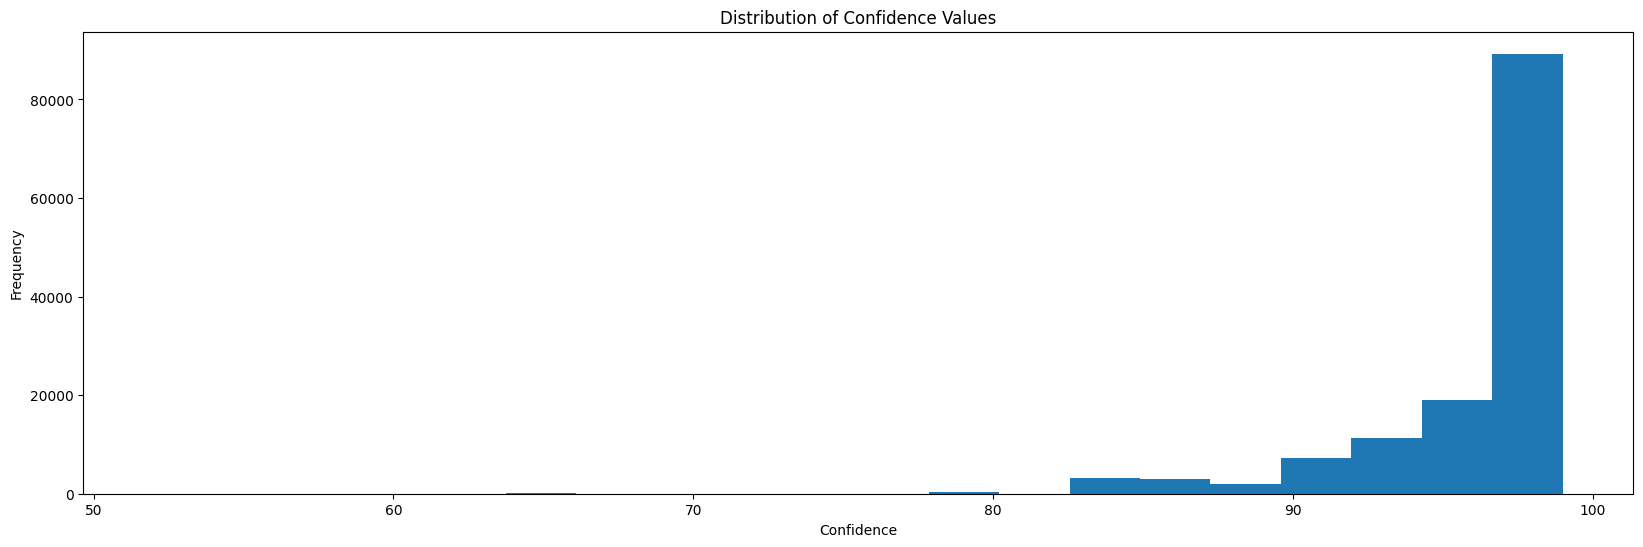

In [31]:
plt.figure(figsize=(20, 6))
plt.hist(trimmed_data['confidence'], bins=20)
plt.title('Distribution of Confidence Values')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

In [32]:
# Remove the records with less then 90% confidence level
trimmed_data = trimmed_data[trimmed_data["confidence"] >= 90]
len(trimmed_data)

126951

In [33]:
# Remove the duplicates that having same reviewerId, asin, reviewText and summary (keeping the one of the copy)
trimmed_data = trimmed_data.drop_duplicates(subset=['reviewerID', 'asin', 'reviewText', 'summary'], keep='last')
len(trimmed_data)

126939

In [34]:
# Detect url
url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
trimmed_data["url"] = trimmed_data['reviewText'].str.contains(url_pattern, na=False)
trimmed_data[trimmed_data["url"]]["reviewText"]

12861                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          My mom loved the gift!\nhttp://www.mcmilliancatfishfarms.webs.com
33882                                                                                                                                                                                                                                                                  

In [35]:
# Remove the records with url
trimmed_data = trimmed_data[trimmed_data["url"] == False]
len(trimmed_data)

126913

In [36]:
# Detect html tag
html_tag_pattern = r'<[^>]+>'
trimmed_data["html"] = trimmed_data['reviewText'].str.contains(html_tag_pattern, na=False)
trimmed_data[trimmed_data["html"]]["reviewText"]

549                                                                                                                                                                                                                                                                                                                                                                                       <a data-hook="product-link-linked" class="a-link-normal" href="/Amazon-com-50-Gift-Card-0109/dp/B001H53QDK/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Amazon.com $50 Gift Card (0109)</a>&nbsp;A great gift idea when you are short on time or do not know what to get someone.
559                                                                                                    <a data-hook="product-link-linked" class="a-link-normal" href="/Bausch-Lomb-Soothe-Lubricant-Eye-Drops-28-Count-Single-Use-Dispensers-Pack-of-2/dp/B001ET7D1K/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Bausch & Lomb Soothe Lubricant Eye Drops, 28-Count Single Use Disp

In [37]:
# Remove the records with html
trimmed_data = trimmed_data[trimmed_data["html"] == False]
len(trimmed_data)

126836

In [38]:
# Total dropped data
dropped_len = len(original_data) - len(trimmed_data)
dropped_len

20358

In [39]:
# Percentage of total retained data
print(f"{(dropped_len / len(original_data) * 100):.2f} %")

13.83 %


In [40]:
trimmed_data.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'language', 'confidence', 'url', 'html'],
      dtype='object')

In [41]:
cleaned_data = trimmed_data[["overall", "reviewText"]].copy()

# Download pre-trained word vectors

In [42]:
%%capture
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [43]:
%%capture
!gdown https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM

In [44]:
%%capture
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

In [45]:
%%capture
!unzip glove.6B.zip

In [46]:
%%capture
!unzip crawl-300d-2M-subword.zip

# Preprocessing

In [47]:
# Apply lowercasing
cleaned_data["preprocess_reviewText"] = cleaned_data["reviewText"].astype(str).str.lower()

In [48]:
# Remove stop words
stop_words      = set(stopwords.words('english'))
negative_words  = {"no", "not", "don't", "aren't", "doesn't", "won't", "wouldn't", "shouldn't", "couldn't"}
stop_words      = stop_words - negative_words
cleaned_data["preprocess_reviewText"] = cleaned_data["preprocess_reviewText"].apply(lambda text: ' '.join(word for word in text.split() if word.lower() not in stop_words))

In [49]:
cleaned_data["preprocess_reviewText"] = cleaned_data["preprocess_reviewText"].str.replace('[^\w\s]', '')


In [50]:
cleaned_data.to_csv("cleaned_data")

# Text representation using TF-IDF


In [51]:
tfidf_model = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_model.fit_transform(cleaned_data['preprocess_reviewText'])

In [52]:
tfidf_df = pd.DataFrame(X_tfidf.todense(), columns=tfidf_model.get_feature_names_out())

In [53]:
print(tfidf_df.columns)

Index(['able', 'again', 'always', 'amazon', 'arrived', 'best', 'birthday',
       'books', 'bought', 'box', 'buy', 'came', 'can', 'card', 'cards',
       'choose', 'christmas', 'convenient', 'could', 'cute', 'daughter', 'day',
       'delivered', 'delivery', 'don', 'easy', 'email', 'everyone',
       'excellent', 'family', 'fast', 'friend', 'gave', 'get', 'gift', 'gifts',
       'give', 'giving', 'go', 'good', 'got', 'great', 'happy', 'idea', 'it',
       'kindle', 'know', 'last', 'like', 'little', 'love', 'loved', 'loves',
       'made', 'make', 'minute', 'money', 'much', 'need', 'never', 'nice',
       'no', 'not', 'one', 'order', 'ordered', 'perfect', 'person', 'present',
       'print', 'product', 'purchase', 'purchased', 'quick', 'really',
       'received', 'recipient', 'right', 'say', 'send', 'sent', 'service',
       'someone', 'something', 'son', 'store', 'thank', 'thanks', 'them',
       'time', 'tin', 'use', 'used', 'want', 'wanted', 'way', 'well', 'worked',
       'would', 

In [54]:
tfidf_df["overall"] = cleaned_data["overall"]

In [60]:
tfidf_df.to_csv("tfidf_data.csv")

# Text representation using Word2Vec

In [61]:
word2vec_model  = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [62]:
word2vec_df = cleaned_data["preprocess_reviewText"].apply(
    lambda text: [word2vec_model[word] for word in text.split() if word in word2vec_model]
    if text else np.zeros((1, word2vec_model.vector_size))
)

In [63]:
word2vec_data = pd.DataFrame({
    "embeddings": word2vec_df,
    "overall": cleaned_data["overall"]
})

In [65]:
word2vec_data.to_csv("word2vec_data.csv")

In [66]:
out_of_vocab_count = 0
for text in cleaned_data["preprocess_reviewText"]:
    for word in text.split():
        if word not in word2vec_model:
            out_of_vocab_count += 1
print("Number of out of vocabulary words in word2vec:", out_of_vocab_count)

Number of out of vocabulary words in word2vec: 281351


In [67]:
out_of_vocab_words = []
for text in cleaned_data["preprocess_reviewText"]:
    for word in text.split():
        if word not in word2vec_model:
            out_of_vocab_words.append(word)
print("Out of vocabulary words in word2vec:", set(out_of_vocab_words))


Out of vocabulary words in word2vec: {'ebook.', 'patrick;s', 'grandparents.', 'version!', 'series!', 'surgury...she', 'feature;', 'time).', 'applebees.', 'glitter!', 'to:', 'event...', "cc's", 'day!)', 'easy"', 'me!!!)', 'degree.', '94404', 'moral.', 'exchanging.', '$0.00', 'college,', '(:', 'easssssssse', "hotel's", 'months.', '9"', '"look."', 'rates.', 'giftee......', "gc's.", 'mcdonalds,', 'respeto.', 'weeks,', 'less!', 'minutes!!!', "wendy's.", 'ecard.', 'cellphone.', "like'", 'books);', 'concerned)', "'a'", 'trying.', 'stored,', 'kalikimaka', 'year"', 'student!', 'years..', 'option...no', 'exceptional,', 'madeline', 'love).', 'quickly-moving', 'thirteen,', 'chang!', 'amazon...ty', 'purposely).', 'low-carb', 'gift-giving...of', 'digits.', 'shalom,', 'prsent', 'cards......always', 'non-feminine', 'packaging!.buy', 'conveinence.', 'delivery".', 'correctly,', "parent's", 'early,', 'lost,', 'mailed.', 'coach.', 'gift-wrap:', '"review"', 'store!!!!', 'ultimately,', 'each.', 'all-round',

In [68]:
out_of_vocab_count = 0
for text in "hi, how are you":
    for word in text.split():
        if word not in word2vec_model:
            out_of_vocab_count += 1
print("Number of out of vocabulary words in word2vec:", out_of_vocab_count)

Number of out of vocabulary words in word2vec: 2


The above simple tests has 2 OOVs, which is "hi," and "are". "hi," is OOV because there is punctuation. "are" is OOV because it is a stop words. It shows that we need to remove punctuations before using word2vec

# Text representation using Spacy

In [69]:
import spacy

nlp = spacy.load("en_core_web_md")
spacy_df = cleaned_data["preprocess_reviewText"].apply(
    lambda text: [token.vector for token in nlp(text)]
    if text else np.zeros((1, nlp.vocab.vectors_length))
)
spacy_data = pd.DataFrame({
    "embeddings": spacy_df,
    "overall": cleaned_data["overall"]
})

In [70]:
spacy_data.to_csv("spacy_data.csv")

In [71]:
out_of_vocab_count = 0
out_of_vocab_words = []
for text in cleaned_data["preprocess_reviewText"]:
    for token in nlp(text):
        if np.all(token.vector == 0):
            out_of_vocab_count += 1
            out_of_vocab_words.append(token.text)
print("Number of out of vocabulary words in spacy:", out_of_vocab_count)
print("Out of vocabulary words in spacy:", out_of_vocab_words)


Number of out of vocabulary words in spacy: 8473
Out of vocabulary words in spacy: ['amazonis', 'shipping+++++', 'alwaysove', 'grehlrt', 'giive', 'gootten', 'prodict', 'workmman', 'givt', 'christmases', "b'ay", 'tahiliani', 'jm2', '7:56am', 'cafix', 'cafix', 'cafix', 'cafix', 'cafix', 'cafix', 'cafix', 'cafix', 'aawl', 'card,10.00', 'sres', 'coffeyville', 'kindel', 'paperwhite', 'allmost', 'safey', 'delivry', 'liaked', 'excllent', 'dispener', 'shiped', 'bacicaly', 'embarressing', 'b001gxrqwo', '892685001089', 'brunello', 'as3ahqfvgaka9kq', 'graceellen@aol.com', 'grossmeyer', 'epurchase', 'prodicted', 'itouch', 'itouch', 'card.look', 'itouch', 'gatormeng', '8gig', 'puchases', 'havehad', 'orderring', 'cerificates', 'fisical', 'dv4', 'wizzes', 'itune', 'ohhhhhhhhhh', 'tokio', 'amozon', 'envelope-', 'delievered', 'hillsdale', '94404', '+16505043985', 'lardavwil@hotmail.com', 'ordersd', 'pruchase', 'itouch', 'itouch', 'ooma', 'recipant', 'delievery', 'was&nbsp', '.72', 'gifdt', 'phillipines

# Text representation using glove

In [72]:
glove_file = './glove.6B.300d.txt'
word_embeddings = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        word, *vector = line.split()
        word_embeddings[word] = np.array(vector, dtype=np.float64)

def sentence_to_vec(sentence, embeddings, dim=300):
    words = sentence.split()
    sentence_vec = np.zeros(dim)
    for word in words:
        if word in embeddings:
            sentence_vec += embeddings[word]
    return sentence_vec / len(words)

glove_df = cleaned_data["preprocess_reviewText"].apply(lambda x: sentence_to_vec(x, word_embeddings))
glove_df = pd.DataFrame(glove_df.tolist(), columns=[f"glove_{i}" for i in range(300)])
glove_df["overall"] = cleaned_data["overall"]

/var/folders/_w/y025p4hs6mbdx0xns5tf3src0000gq/T/ipykernel_78740/1988483377.py:14: RuntimeWarning: invalid value encountered in divide
  return sentence_vec / len(words)


In [73]:
glove_df.to_csv("glove_data.csv")

In [74]:
out_of_vocab_count = 0
for text in cleaned_data["preprocess_reviewText"]:
    for word in text.split():
        if word not in word_embeddings:
            out_of_vocab_count += 1
print("Number of out of vocabulary words in glove:", out_of_vocab_count)

Number of out of vocabulary words in glove: 296628


In [75]:
print(glove_df.shape)

(126836, 301)


In [76]:
out_of_vocab_count = 0
for text in cleaned_data["preprocess_reviewText"]:
    for word in text.split():
        if word not in word_embeddings:
            out_of_vocab_count += 1
            # print(word)
            if out_of_vocab_count >= 20:
                break

print("Number of out of vocabulary words in glove:", out_of_vocab_count)

limitations,
site?
benefit?
also,
cards,
card....
them...
shopper,
and,
happy.
said,
member.
handling...
cards?
$13.
$50
gifts,
out.
sorry.
"sorry".
presents.
helpful!
card.
can't
excellent!
perfect,
card!
shipping+++++
what's
card,
items.
have,
$25
gift.
card.
$100.
teen.
amazon.
alwaysove
amazon!
always.
it,
anyone.
this?
don't
him.
card,
gift.
well-received.
grehlrt.
card.
don't
gift,
gifts.
giving.
giive
price,
workmman
really,
can't
i'm
say?
hello:
card!
give.
doesn't
amazon,
card.
card.
people.
wonderfull
card!!!
it.
gift.
it!
charges.
fast,
gift,
spending.
everything...one
support.
amazon,
son.
says.
gift.
online!
brother,
birthdays.
desires.
exception.
card.
can't
books.
spenders!
law.......he
"i'll
activated.
it.
gift.
pain.
card,it
card...
cards.
wouldn't
couldn't
them.
monday,
cards,
amazon,
card.
variety.
price.
don't
frequently.
occasion!
retailer;
request:
use.
sense!
apparel.
read;
gift.
myself.
say?
kidding?
amazon,
what's
gift.
can't
member.
don't
approaching,
cards,
f

# Text representation using fasttext

In [84]:
# Load the fastText model
fasttext_model = fasttext.load_model('crawl-300d-2M-subword.bin')

# Ensure the text is encoded in UTF-8, handling non-ASCII characters
def ensure_utf8_encoding(text):
    # Replace non-ASCII characters with a space and encode to UTF-8
    return re.sub(r'[^\x00-\x7F]+', ' ', text).encode('utf-8', 'ignore').decode('utf-8')

# Clean and encode the text data
cleaned_data["preprocess_reviewText"] = cleaned_data["preprocess_reviewText"].apply(ensure_utf8_encoding)

# Generate sentence vectors for each review
fasttext_df = cleaned_data["preprocess_reviewText"].apply(lambda x: fasttext_model.get_sentence_vector(x))
fasttext_df = pd.DataFrame(fasttext_df.tolist(), columns=[f"fasttext_{i}" for i in range(300)])

# Append the 'overall' column from the original DataFrame
fasttext_df["overall"] = cleaned_data["overall"]

In [85]:
# Save the processed data to a CSV file with UTF-8 encoding
fasttext_df.to_csv("fasttext_data.csv", encoding='utf-8')


In [88]:
# Initialize a counter for out-of-vocabulary words
out_of_vocab_count = 0

# Iterate through the preprocessed text
for text in cleaned_data["preprocess_reviewText"]:
    for word in text.split():
        try:
            if word not in fasttext_model.words:
                out_of_vocab_count += 1
        except UnicodeDecodeError:
            # print(f"Unicode decode error encountered with word: {word}")
            pass

# Print the count of out-of-vocabulary words
print("Number of out of vocabulary words in fasttext:", out_of_vocab_count)

KeyboardInterrupt: 

# Build SVM
1. Load the TF-IDF represented data.
2. Split the data into training and testing sets, ensuring stratification.
3. Build the initial SVM model.
4. Fine-tune the model using grid search.
5. Evaluate the model's performance with an accuracy report and confusion matrix.
6. Make predictions on the test dataset.

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Function to convert ratings to sentiment
def convert_to_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Load TF-IDF data
tfidf_data = pd.read_csv("tfidf_data.csv")
random_state = 42

# Print the data types of the dataset columns
print(tfidf_data.dtypes)

# Convert 'overall' ratings to sentiment labels
tfidf_data['sentiment'] = tfidf_data['overall'].apply(convert_to_sentiment)

# Split data into features and target
X = tfidf_data.drop(['overall', 'sentiment'], axis=1)  # Assuming 'overall' and 'sentiment' are the only non-feature columns
y = tfidf_data['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

# Initialize SVM with linear kernel
svm_model = SVC(kernel='linear', probability=True, random_state=random_state)

Unnamed: 0      int64
able          float64
again         float64
always        float64
amazon        float64
               ...   
well          float64
worked        float64
would         float64
wrong         float64
overall       float64
Length: 102, dtype: object


In [90]:
# Fine-tuning using GridSearchCV
parameters = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(svm_model, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Evaluate the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred = grid_search.predict(X_test)

In [ ]:
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=['Positive', 'Neutral', 'Negative']))
print("Classification Report:\n", classification_report(y_test, y_pred, labels=['Positive', 'Neutral', 'Negative']))


# Make predictions on the test set using the best model
predictions = grid_search.predict(X_test)


# Example Predictions on the Test Dataset
example_indices = [0, 5, 10]  # Choose indices appropriate for your test set size
example_reviews = X_test.iloc[example_indices]
example_predictions = grid_search.predict(example_reviews)

# Display the example predictions
for i, index in enumerate(example_indices):
    print(f"Review Index: {index}, Predicted Sentiment: {example_predictions[i]}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# SVM Model Evaluation
svm_predictions = best_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)

# Output the results
print(f"SVM Model - Accuracy: {svm_accuracy}")
print(f"SVM Model - Precision: {svm_precision}")
print(f"SVM Model - Recall: {svm_recall}")
print(f"SVM Model - F1 Score: {svm_f1}")
print(f"SVM Model - Confusion Matrix:\n{svm_confusion_matrix}")


In [ ]:
"""
Todo

1. copy the lexicon model of 3 sentiment analysis to here
2. use the three sentiment analysis model to compare the result of svm
"""

# # Assuming `lexicon_model` is a function or trained model that can predict sentiment based on a lexicon approach

# # Lexicon Model Evaluation on the same test data
# lexicon_predictions = lexicon_model.predict(X_test)  # This would be your own implementation of the lexicon prediction
# lexicon_accuracy = accuracy_score(y_test, lexicon_predictions)
# lexicon_precision = precision_score(y_test, lexicon_predictions)
# lexicon_recall = recall_score(y_test, lexicon_predictions)
# lexicon_f1 = f1_score(y_test, lexicon_predictions)
# lexicon_confusion_matrix = confusion_matrix(y_test, lexicon_predictions)

# # Output the results
# print(f"Lexicon Model - Accuracy: {lexicon_accuracy}")
# print(f"Lexicon Model - Precision: {lexicon_precision}")
# print(f"Lexicon Model - Recall: {lexicon_recall}")
# print(f"Lexicon Model - F1 Score: {lexicon_f1}")
# print(f"Lexicon Model - Confusion Matrix:\n{lexicon_confusion_matrix}")

# # Comparison
# # Here you would compare the metrics from the SVM model and the Lexicon model to see which performs better on your test data.
# # You might want to output a table or a chart comparing the different metrics for each model side by side.
